In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import *

from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.tree import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

<br>

# Different way of combining models
---


* Decision tree to have models for different places
* Mixture of experts
* Drop-out comparison? Parameter sharing?

<br>

### Bagging

To approximate the function $y = f(x)$, we can train $K$ different models and combine them, for instance by:

* Taking their average for regression problems
* Counting their votes for classification problems

Assuming the estimations of the models are of the form $y_k(x) = h(x) + \epsilon_k(x)$, where $h(x)$ is the target function and $\epsilon_k$ represents the error for model $k$, then the average of the estimators has a much lower error:

&emsp; $\displaystyle y(x) = \frac{1}{K} \sum_k y_k(x)$
&emsp; $\implies$
&emsp; $\displaystyle E_x[(y(x) - h(x))^2] = E_x[\big (\frac{1}{K} \sum_k \epsilon_k(x) \big )^2]$

If all $K$ models are independent, and we assume the mean of the error to be zero, we have:

&emsp; $\operatorname{Cov}_x[\epsilon_i(x) \epsilon_j(x)] = E_x[\epsilon_i(x) \epsilon_j(x)] - E_x[\epsilon_i(x)] E_x[\epsilon_j(x)] = \delta_{ij}$
&emsp; $\implies$
&emsp; $\displaystyle E_x[(y(x) - h(x))^2] = \frac{1}{K^2} \sum_k E_x[\epsilon_k(x)^2]$

We therefore see that if all $K$ models are independent, the error of the combined model is $K$ times smaller than the average error of the models taken separately. The problem of course, is that most of the time, the assumption of independence is very much not verified.

<br>

### Boosting

The principle of Boosting is to combine $K$ different models such that each model learns to correct the errors of the previous model. Then we combine all models with weights that depends on their respective accuracy:

* For classification, data-points that are often miss-classified by the $m_1 \dots m_{k-1}$ models are given more weights for the $m_k$ model
* For regression, models are trained on the residual errors (the different between target and predicted) of previous models

**Boosting works much better than bagging** and can lead to surprisingly good results. For classification, it can even give amazing results when the base classifiers are weak and barely better and random guessers.

<br>

### Conditional Mixture Models

**todo**

For instance for regression, the error function of the $m$'s classifier becomes:

&emsp; $\displaystyle E = \frac{1}{N} \sum_n w_n^{(k)} (y_k(x) - t)^2$
&emsp; where
&emsp; $w_n^{(k)}$ is the weight of the $n^{th}$ sample for the $k^{th}$ model

<br>

### Mixture of experts

**todo + difference with latent variable models**

<br>

# Boosting Examples
---

* Formula for regression
* Formula for classification

**todo:** Boosting (AdaBoost)

**todo:** Learning on residuals?

**todo:** Link with residuals networks?

<br>

### Regression example

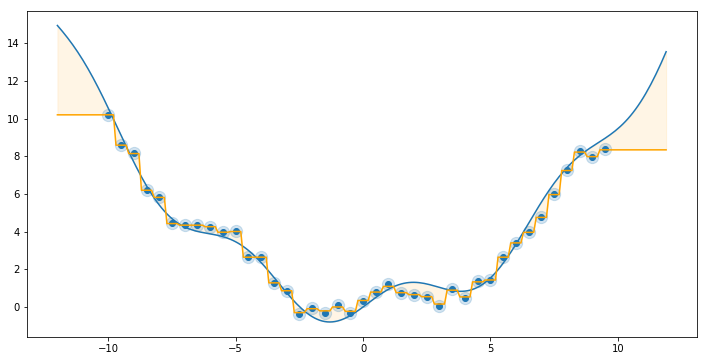

Total error: 2.087695990201788


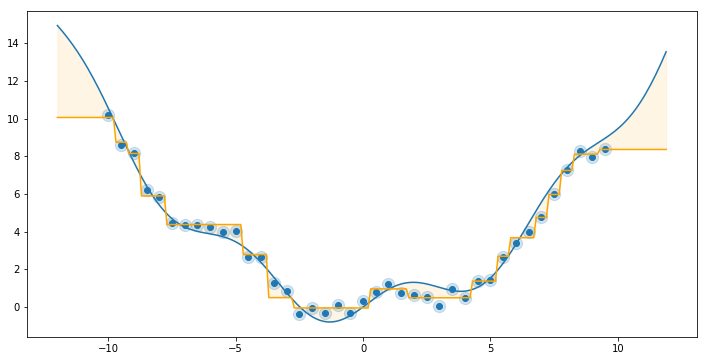

Total error: 2.1544739335658445


In [34]:
class ScikitBoostModel:
    def __init__(self):
        self.regressor = GradientBoostingRegressor()
        
    def fit(self, xs, ys):
        self.regressor.fit(np.expand_dims(xs, -1), ys)
    
    def predict(self, xs):
        return self.regressor.predict(np.expand_dims(xs, -1))
    

class MyBoostModel:
    def __init__(self, nb_models: int, tree_depth: int):
        self.models = [DecisionTreeRegressor(max_depth=tree_depth) for _ in range(nb_models)]
    
    def fit(self, xs, ys):
        xs = np.expand_dims(xs, -1)
        residuals = ys.copy()
        for i, model in enumerate(self.models):
            model.fit(xs, residuals)
            pred_ys = model.predict(xs)
            residuals -= pred_ys
        
    def predict(self, xs):
        xs = np.expand_dims(xs, -1)
        ys = np.zeros(shape=len(xs))
        for i, model in enumerate(self.models):
            ys += model.predict(xs)
        return ys


def f_at(xs):
    return 0.1 * xs ** 2 + np.sin(xs)


def show_results(model):
    pred_ys = model.predict(test_xs)
    plt.figure(figsize=(12,6))
    plt.plot(test_xs, test_ys)
    plt.plot(test_xs, pred_ys, color='orange')
    plt.fill_between(test_xs, test_ys, pred_ys, alpha=0.1, color='orange')
    plt.scatter(train_xs, train_ys, color='tab:blue')
    plt.scatter(train_xs, train_ys, s=150, alpha=0.2, color='tab:blue')
    plt.show()
    print("Total error:", np.linalg.norm(test_ys - pred_ys) * (test_xs[1] - test_xs[0]))

    
train_xs = np.arange(-10, 10, 0.5)
train_ys = f_at(train_xs) + np.random.normal(loc=0., scale=0.5, size=len(train_xs))
test_xs = np.arange(-12, 12, 0.1)
test_ys = f_at(test_xs)

model = ScikitBoostModel()
model.fit(train_xs, train_ys)
show_results(model)

model = MyBoostModel(nb_models=10, tree_depth=2)
model.fit(train_xs, train_ys)
show_results(model)

<br>

# Mixture Density Networks
---

**TODO: MIXTURE OF EXPERTS + PARAMETER SHARING?**

Artificial Neural Networks can be used to approximate any function $y = f(x)$.

In some situations though, we are **trying to learn a relation and not a function** (a function is a special type of relation for which there is a single output for a given input). This occurs particularly often when:

* trying to learn **inverse mappings** (that is, trying the find the $x$ that led to a $y$)
* trying to find **the cause from the effect** (as there might be several causes)
* dealing with **implicit functions** (such as parametric curves) for which observed values linked by an unknown variable

We show here that by adapting the **error function** and the associated outputs, we can make ANN learn any relation and not only any function.

<br>

### Mono-modal ANN & error functions

Typical regressions with Minimum Square Error are equivalent to maximizing the likelihood of the data, with the assumption that the distribution of target values given the input is gaussian (gaussian noise around the most probable value):

&emsp; $\displaystyle p(t|x) = \mathcal{N}(t|\mu(x), \Sigma) = (2 \pi \vert \Sigma \vert)^{\textstyle -\frac{D}{2}} e^{\textstyle -\frac{1}{2} (t - \mu(x))^T \Sigma^{-1} (t - \mu(x))}$
&emsp; where
&emsp; $\mu(x)$ is the function we are trying to learn

Maximizing the log likelihood of our parameters $w$ on the whole data set:

&emsp; $\displaystyle \log p(D|w) = \prod p(t_n|x_n, w) = -\frac{1}{2} \sum (t_n - f(x_n, w))^T \Sigma^{-1} (t_n - f(x_n, w)) + const$

If we assume an isotropic white noise, which means that the covariance matrix $\Sigma$ of the noise is equal to $\sigma^2 I$, maximizing the likelihood is equivalent to minimizing the least squares error:

&emsp; $\displaystyle E = \sum (t_n - f(x_n, w))^2$

Minimizing the MSE will therefore work correctly when approximating function, but will completely **fail at modeling the distribution $p(y|x)$ when this distribution is multi-modal**, typically when it is not a function:

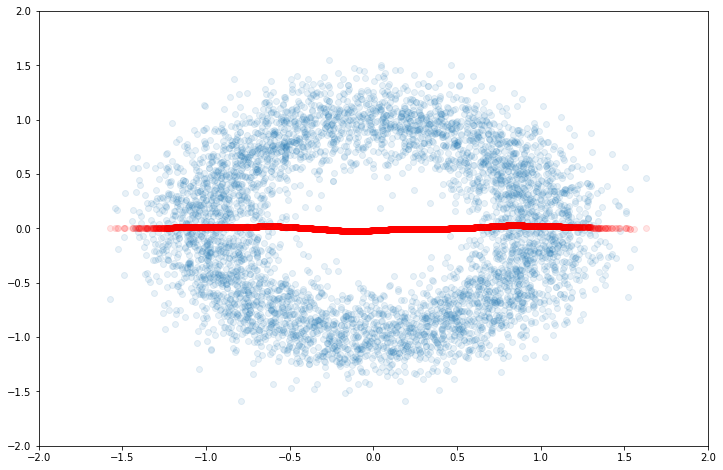

In [8]:
"""
Our multi-modal distribution, which is an implicit curve x^2 + y^2 = 1 plus some noise
"""

n = 5000
thetas = np.random.uniform(-np.pi, np.pi, size=n)
xs = np.cos(thetas) + np.random.normal(loc=0., scale=0.2, size=n)
ys = np.sin(thetas) + np.random.normal(loc=0., scale=0.2, size=n)

"""
Training a model built for mono-modal distributions
"""

model = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 1))

model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
ds = data.TensorDataset(torch.FloatTensor(xs).unsqueeze(-1), torch.FloatTensor(ys).unsqueeze(-1))
loader = data.DataLoader(ds, shuffle=True, batch_size=100)
for _ in range(25):
    for x, y in loader:
        y_p = model(x)
        loss = criterion(y_p, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

model.eval()
y_pred = model(torch.FloatTensor(xs).unsqueeze(-1)).detach().numpy()

"""
Showing the really bad results
"""

plt.figure(figsize=(12, 8))
plt.scatter(xs, ys, alpha=0.1)
plt.scatter(xs, y_pred, alpha=0.1, color='red')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

<br>

### Multi-modal ANN & error function

Let us now model our output as multi-modal and approximate this with several gaussians:

&emsp; $p(t|x) = \sum \pi_k(x) \mathcal{N}(t|\mu_k(x),\Sigma(x))$

We want to maximize the likelihood of the data given the parameters:

&emsp; $\displaystyle \log p(D|w) = \sum \log p(t_n|x_n) = \sum_n \log \sum_k \pi_k(x_n) N(t|\mu_k(x_n), \Sigma(x_n))$

There are several techniques to optimize this kind of errors functions where the logarithm does not reach the exponential and therefore does not lead to a nice formula such as the least square error. One of these techniques is the **Expectation Maximization** algorithm, which requires the introduction of **latent variables**.

In our case, we will simply modify our ANN to **return several inputs** instead of one, and directly optimize with SGD the error function equal to the negative log likelihood described above. The outputs of our **mixture density network** will be all the:

* $\pi_k(x) \implies$ K parameters for K modes
* $\mu_k(x) \implies$ K * D parameters for K modes and D output dimensions
* $\sigma_k^2(x) \implies$ K parameters for K modes (we postulate $\Sigma_k = \sigma_k^2 I$)

This is $K(D+2)$ parameters in total. Note that we could have made other choices:

* Choose all $\sigma_k^2$ to be equal (the error is the same for all distributions)
* Choose a general form for $\Sigma$ (the $D$ dimensions of the inputs are not independent)

The model is implemented below with $K =$ 2 gaussians, $D =$ 1 dimensional outputs and therefore $K(D+2) = 6$ network ouputs. We see that its ability to model the distribution $p(y|x)$ is far greater than with our previous error function.

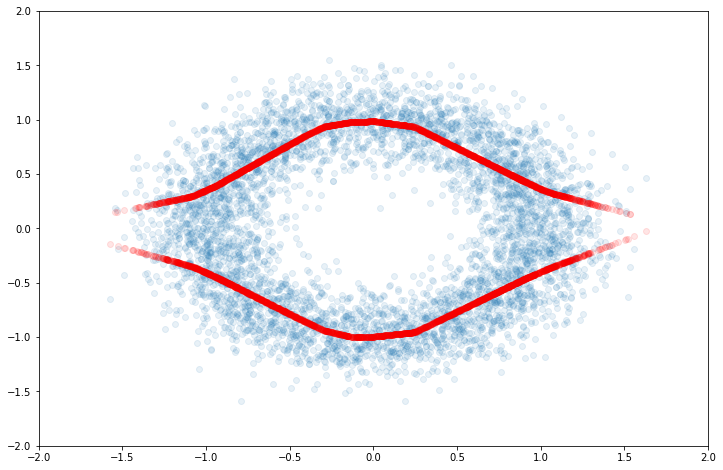

In [11]:
"""
Custom Neural Network for 2 modes, with the associated error function
"""

class MixtureDensityNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 6))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, xs):
        return self.fc(xs)
    
    def predict(self, xs) -> List[float]:
        outputs = []
        ys = self(xs)
        for y in ys:
            ps = self.softmax(y[:2])  # First two parameters are probabilities
            ms = y[2:4] # Second parameters are means
            ix = torch.distributions.categorical.Categorical(probs=ps).sample()
            outputs.append(ms[ix].item())
        return outputs


def loss_function(y_params, y):
    ps = y_params[:,:2]  # First two parameters are probabilities
    ps = nn.Softmax(dim=-1)(ps)
    ms = y_params[:,2:4] # Second parameters are means
    vs = torch.exp(y_params[:,4:])  # Third parameters are variances
    probs = ps * 1 / torch.sqrt(2 * math.pi * vs ** 2) * torch.exp(- (ms - y) ** 2 / (2 * vs))
    # probs = ps * torch.exp(- (ms - y) ** 2)
    probs = torch.sum(probs, axis=-1)
    loss = -1 * torch.sum(torch.log(probs))
    return loss


"""
Training our model built for 2-modes distributions
"""

model = MixtureDensityNetwork()
model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
ds = data.TensorDataset(torch.FloatTensor(xs).unsqueeze(-1), torch.FloatTensor(ys).unsqueeze(-1))
loader = data.DataLoader(ds, shuffle=True, batch_size=100)
for _ in range(25):
    for x, y in loader:
        y_params = model(x)
        loss = loss_function(y_params, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


model.eval()
y_pred = model.predict(torch.FloatTensor(xs).unsqueeze(-1))
plt.figure(figsize=(12, 8))
plt.scatter(xs, ys, alpha=0.1)
plt.scatter(xs, y_pred, alpha=0.1, color='red')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()